# Sentiment Analysis Using Naive Bayes Classifier 

This example was from Northwestern's MSiA Text Analytics course. I will demonstrate how to implement naive bayes classifier from scratch. 

Data: 
- http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz

Other Sources:
- DefaultDict: https://www.ludovf.net/blog/python-collections-defaultdict/


Direction from Text Analytics HW: 
- Construct a baseline naive Bayes classifier that uses only words as features. This is the type of naive Bayes classifier we discussed in class, which is equivalent to a unigram language model for each class (positive and negative). To construct it, you’ll get the frequencies of every word in the vocabulary in each class, add 1 to all word frequencies in each class (Laplace smoothing), and then normalize each frequency by dividing by the total to get a probability distribution. Finally, take the log of each probability to get a log-probability of each word for each class. [Note that this might be easiest using a vector library like python’s numpy .] To apply the naive Bayes classifier, you’ll calculate the log probability of a test review under each class by summing the log probabilities of each word in the review. (Ignore new words in the test reviews that weren’t in training, since your models don’t assign them a probability.) Finally, classify according to whichever log probability is higher. (Recall that log probabilities are always negative, and -2 is higher than -4.)

In [8]:
# import packages 
import glob
import os 
import re 
import pandas as pd
import numpy as np 
from collections import defaultdict
import string
import matplotlib.pyplot as plt

In [10]:
# GET FILE NAMES 
path_pos = 'review_polarity/txt_sentoken/pos/*.txt'
file_names_pos = sorted(glob.glob(path_pos))

path_neg = 'review_polarity/txt_sentoken/neg/*.txt'
file_names_neg = sorted(glob.glob(path_neg))

file_names_pos[:10]

['review_polarity/txt_sentoken/pos/cv000_29590.txt',
 'review_polarity/txt_sentoken/pos/cv001_18431.txt',
 'review_polarity/txt_sentoken/pos/cv002_15918.txt',
 'review_polarity/txt_sentoken/pos/cv003_11664.txt',
 'review_polarity/txt_sentoken/pos/cv004_11636.txt',
 'review_polarity/txt_sentoken/pos/cv005_29443.txt',
 'review_polarity/txt_sentoken/pos/cv006_15448.txt',
 'review_polarity/txt_sentoken/pos/cv007_4968.txt',
 'review_polarity/txt_sentoken/pos/cv008_29435.txt',
 'review_polarity/txt_sentoken/pos/cv009_29592.txt']

## SENTIMENT ANALYSIS TRAINING 

In [ ]:
def sentiment_train(start, end): 
    # init default dict 
    frequencies_pos = defaultdict(int)
    frequencies_neg = defaultdict(int)

    # get word frequencies 
    for i in range(start,end): 
        ## positive set 
        data = open(file_names_pos[i],'r').read()
        # remove punctuation 
        translator = str.maketrans('', '', string.punctuation)
        # split into tokens 
        tokens = data.translate(translator).split() 
        # loop through each word and count 
        for word in tokens: 
            frequencies_pos[word] += 1 
        
        ## negative set # same as above 
        data = open(file_names_neg[i],'r').read()
        tokens = data.translate(translator).split()
        for word in tokens: 
            frequencies_neg[word] += 1     
        
        # get unique vocabulary list 
        vocabulary = list(set(list(set(frequencies_pos.keys())) + list(set(frequencies_neg.keys()))))
        V = len(vocabulary)
        
        # init probabilities dict s
        probabilities = dict()
        
        # get total word count in each class 
        total_pos_wc = sum(frequencies_pos.values())
        total_neg_wc = sum(frequencies_neg.values())

        # loop through each word and get word probability 
        for i in vocabulary:
            # positive class 
            if i in frequencies_pos.keys():
                pos_wc = frequencies_pos[i]
            else: 
                pos_wc = 0
            # negative class 
            if i in frequencies_neg.keys():
                neg_wc = frequencies_neg[i]
            else: 
                neg_wc = 0

            # word probability with laplace smoothing 
            pr_pos = (pos_wc + 1)/float((total_pos_wc+V))
            pr_neg = (neg_wc + 1)/float((total_neg_wc+V))

            # assign log probabilities 
            # dict method 
            probabilities[i] = [np.log(pr_pos),np.log(pr_neg)]       
            # list method 
            # probabilities.append((i,np.log(word_prob_pos),np.log(word_prob_neg)))
            
    return probabilities
        
# example - train using first 100 files from positive and negative examples 
probabilities = sentiment_train(start=0, end=100)



In [19]:
# look at the log probability for word like for positive and negative class 
probabilities['like']

[-6.0650665998002404, -5.8893484928014894]

## SENTIMENT ANALYSIS TESTING 

In [ ]:
def sentiment_test(start, end, probabilities=probabilities): 
    # init document list for each class 
    test_pos = []
    test_neg = [] 

    # loop through the data 
    for i in range(start, end): 
        # read data 
        data_pos = open(file_names_pos[i],'r').read()
        data_neg = open(file_names_neg[i],'r').read()
        
        # remove punctuation 
        translator = str.maketrans('', '', string.punctuation)
        tokens_pos = data_pos.translate(translator).split() 
        tokens_neg = data_neg.translate(translator).split() 
        
        # (doc_position, actual class, tokens list)
        test_pos.append((i,1,tokens_pos))
        test_neg.append((i,-1,tokens_neg))
    
    # combine test set for both positive and negative 
    test_set = test_pos + test_neg 
    
    # init result list     
    result = [] 
    
    # PREDICT FOR TEST SET 
    for position, actual_class, word_list in test_set: 
        # reset log probability score for each class 
        pr_pos = 0 
        pr_neg = 0 

        # sum of the word probabilities for each document
        for word in word_list: 
            if word in probabilities.keys(): 
                pr_pos += (probabilities[word][0])        
                pr_neg += (probabilities[word][1])
    
        # log probabilities are negative, smaller is higher 
        # format: (position, actual class, predicted class)
        if pr_pos > pr_neg: 
            result.append((position,actual_class,1)) 
        else: 
            result.append((position,actual_class,-1)) 
        
    return result 

# example - using the probabilities computed above, test on the 100 files from 500 to 600. 
test = sentiment_test(start=500, end=600, probabilities=probabilities)

In [18]:
# shows that 501th file in positive folder was classified as positive 
test[1]

(501, 1, 1)

## SENTIMENT RESULT

In [61]:
def sentiment_result(train_start, train_end, test_start, test_end): 
    # run sentiment_train and sentiment_test 
    test = sentiment_test(start=test_start, end=test_end, 
                            probabilities=sentiment_train(start=train_start, end=train_end))
    # convert to dataframe 
    df = pd.DataFrame(test,columns=['position','actual','predicted'])
    
    # confusion matrix 
    table = pd.crosstab(df.actual,df.predicted, margins = True)
    # accuracy =(TP + TN ) / All 
    accuracy = (table.iloc[0,0] + table.iloc[1,1])/(table.iloc[2,2])
    # precision = true positive / true positive + false positive 
    precision = table.iloc[1,1]/(table.iloc[2,1])
    # recall = true positive / true positive + false negative
    recall = table.iloc[1,1]/(table.iloc[1,2])
    # f1-score = 2*Precision*Recall/(Precision+Recall)
    fscore = 2*precision*recall/(precision+recall)
    
    return (precision, recall, fscore, accuracy)

r1 = sentiment_result(0, 100, 600, 800)
r2 = sentiment_result(0, 300, 600, 800)
r3 = sentiment_result(0, 500, 600, 800)
r4 = sentiment_result(0, 600, 600, 800)
r5 = sentiment_result(0, 800, 800, 1000)

print(r1)
print(r2)
print(r3)
print(r4)

(0.73611111111111116, 0.79500000000000004, 0.76442307692307709, 0.755)
(0.81481481481481477, 0.77000000000000002, 0.79177377892030842, 0.79749999999999999)
(0.80000000000000004, 0.83999999999999997, 0.81951219512195117, 0.81499999999999995)
(0.82524271844660191, 0.84999999999999998, 0.83743842364532017, 0.83499999999999996)


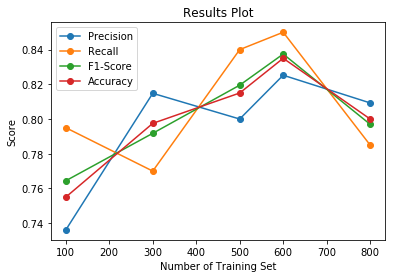

In [91]:
results = pd.DataFrame({'100':r1,'300':r2,'500':r3,'600':r4,'800':r5})
results.index =['precision','recall','f1-score','accuracy']

plt.plot(results.iloc[0,:],'-o', label='Precision')
plt.plot(results.iloc[1,:],'-o', label='Recall')
plt.plot(results.iloc[2,:],'-o', label='F1-Score')
plt.plot(results.iloc[3,:],'-o', label='Accuracy')

plt.title('Results Plot')
plt.xlabel('Number of Training Set')
plt.ylabel('Score')
plt.legend()
plt.show()

In [95]:
results

,100,300,500,600,800
precision,0.736111,0.814815,0.800000,0.825243,0.809278
recall,0.795000,0.770000,0.840000,0.850000,0.785000
f1-score,0.764423,0.791774,0.819512,0.837438,0.796954
accuracy,0.755000,0.797500,0.815000,0.835000,0.800000


## ETC 

In [35]:
sorted(frequencies_pos.items(),key= lambda x: x[1],reverse=True)[:10]

[('the', 41385),
 ('a', 20133),
 ('and', 19777),
 ('of', 18550),
 ('to', 16436),
 ('is', 14050),
 ('in', 11612),
 ('that', 7754),
 ('as', 6463),
 ('it', 6416)]

In [2]:
probabilities

{'jones': [-8.9828373318845198, -10.118612372922961],
 'obarrs': [-11.285422424878567, -10.524077481031126],
 'smiling': [-9.8991280637586758, -11.217224661591072],
 'putting': [-10.186810136210456, -9.8309303004711808],
 'paulie': [-10.592275244318621, -11.217224661591072],
 'disbanded': [-11.285422424878567, -10.524077481031126],
 'recovering': [-10.592275244318621, -11.217224661591072],
 'epitome': [-10.592275244318621, -10.118612372922961],
 'lifetime': [-10.186810136210456, -10.524077481031126],
 'stoltz': [-10.592275244318621, -11.217224661591072],
 'game': [-8.512833702638785, -8.44463593935129],
 'benignis': [-9.6759845124444652, -11.217224661591072],
 'regurgitated': [-11.285422424878567, -10.524077481031126],
 'academic': [-10.186810136210456, -11.217224661591072],
 'myriad': [-10.592275244318621, -10.524077481031126],
 'foulmouthed': [-10.592275244318621, -10.524077481031126],
 'deservedly': [-10.592275244318621, -10.118612372922961],
 'clocked': [-11.285422424878567, -10.52